# Analyse des données de films et prédiction des performances au box-office avec l'API TMDb

#### Auteurs : Agnimo Yedidia, Emily Bonnart, Joséphine Mayans

### Introduction

##### Ce notebook présente notre projet final pour le cours Python pour la data-science. Il se compose d’un jeu de données récupéré et nettoyé, d’une partie visualisation et analyse descriptive, et d’une partie modélisation. Un autre notebook décrivant l'extraction des données via l'API a été placé à part. Nous utilisons ici le fichier pickle obtenu à l'aide de cette extraction. Nous procéderons au nettoyage de cette base de données dans la première partie. 

##### Contexte : Le choix du sujet a été plutôt rapide. Après avoir sondé nos intérêts communs, nous avons vite décidé de travailler sur le cinéma pour élaborer un modèle prédictif. Ce choix s’est confirmé lorsque nous avons découvert l’API TMDB, gratuit, qui nous fournissait les données dont nous avions besoin.

#### Problématique :

##### Le cinéma est une industrie générant des milliards de dollars chaque année. Prédire les recettes au box-office est une préoccupation majeure pour les studios, les producteurs et les investisseurs. Des prévisions précises peuvent aider les décideurs à allouer des ressources et à prendre des décisions éclairées sur les films à produire et à distribuer. Actuellement, Avatar apparait comme le plus gros succès du box-office mondial avec plus de 2,8 milliards $ de recette. Mais qu’est-ce qui fait qu’un film aura du succès ? Les studios de cinéma peuvent-ils prévoir la recette d’un film à partir de certaines de ses caractéristiques telles que le budget, la durée, l’année de sortie, la popularité ? Ce sont les questions auxquelles nous avons tâché de répondre lors de ce projet, à partir d'un modèle d'apprentissage automatique capable de prédire les recettes au box-office des films en fonction des données de l'API TMDb.

#### Imports

In [ ]:
pip install wordcloud

In [225]:
# import modules
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud
import pickle
import plotly.express as px
import time
import requests

# I. Nettoyage de la base de données

##### On utilise le dataframe généré dans le notebook présentant l'API.

In [216]:
movies_df = pd.read_pickle("./data/movies_tmdb.pkl")

##### On supprime les lignes contenant des 0 pour le budget ou la recette :

In [218]:
movies_df = movies_df.query('budget > 0 and revenue > 0')
print(movies_df.shape)
movies_df.head(2)

(4974, 25)


adult                     backdrop_path  \
0  False   /Yc9q6QuWrMp9nuDm5R8ExNqbEq.jpg   
3  False  /tuDhEdza074bA497bO9WFEPs6O6.jpg   

                               belongs_to_collection     budget  \
0  {'id': 87096, 'name': 'Avatar Collection', 'po...  237000000   
3  {'id': 420, 'name': 'The Chronicles of Narnia ...  180000000   

                                              genres  \
0  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
3  [{'id': 12, 'name': 'Adventure'}, {'id': 10751...   

                               homepage     id    imdb_id original_language  \
0  https://www.avatar.com/movies/avatar  19995  tt0499549                en   
3                                          411  tt0363771                en   

                                      original_title  ... release_date  \
0                                             Avatar  ...   2009-12-15   
3  The Chronicles of Narnia: The Lion, the Witch ...  ...   2005-12-07   

      revenue runtime                                   spoken_languages  \
0  2920357254     162  [{'english_name': 'English', 'iso_639_1': 'en'...   
3   745013115     143  [{'english_name': 'English', 'iso_639_1': 'en'...   

     status                            tagline  \
0  Released        Enter the world of Pandora.   
3  Released  Evil Has Reigned For 100 Years...   

                                               title  video vote_average  \
0                                             Avatar  False        7.543   
3  The Chronicles of Narnia: The Lion, the Witch ...  False        7.102   

  vote_count  
0      27045  
3       8982  

[2 rows x 25 columns]

##### Sur 10 000 films, il ne nous en reste plus que 4974.

##### On retire les colonnes inutiles :

In [219]:
movies_df=movies_df.drop(columns =['adult','backdrop_path', 'belongs_to_collection', 'homepage', 'id', 'imdb_id', 
                                  'original_title','overview','poster_path', 'status', 'video'])

##### Après avoir supprimé les colonnes dont nous n’avions pas besoin, nous nettoyons certaines variables, telles que le genre présenté sous forme de listes pas faciles à manipuler (exemple : [{‘id’: 80, ‘name’: ‘Crime’}, {‘id’: 35, ‘name’ :’Adventure’}]...) :

In [220]:
def cleaning_variable(cell):
    if isinstance(cell, list):
        variable = []
        for element in cell:
            variable.append(element["name"])
    return variable

#Replace empty list by nan.
def replace_empty_lists(x):
    if isinstance(x,list) and not x :
        return np.nan
    return x

#List of columns to which apply the function
colnames = ['genres','production_countries','production_companies']

#Apply the functions
for colname in colnames:
    try:
        movies_df[colname] = movies_df[colname].apply(cleaning_variable)
    except:
        pass
    try:
        movies_df[colname] = movies_df[colname].apply(replace_empty_lists)
    except:
        pass
    
movies_df.head(2)

budget                                         genres original_language  \
0  237000000  [Action, Adventure, Fantasy, Science Fiction]                en   
3  180000000                   [Adventure, Family, Fantasy]                en   

   popularity                               production_companies  \
0    3086.550  [20th Century Fox, Ingenious Media, Dune Enter...   
3     539.113  [Walt Disney Pictures, Walden Media, C.S. Lewi...   

                         production_countries release_date     revenue  \
0  [United States of America, United Kingdom]   2009-12-15  2920357254   
3  [United Kingdom, United States of America]   2005-12-07   745013115   

   runtime                                   spoken_languages  \
0      162  [{'english_name': 'English', 'iso_639_1': 'en'...   
3      143  [{'english_name': 'English', 'iso_639_1': 'en'...   

                             tagline  \
0        Enter the world of Pandora.   
3  Evil Has Reigned For 100 Years...   

                                               title  vote_average  vote_count  
0                                             Avatar         7.543       27045  
3  The Chronicles of Narnia: The Lion, the Witch ...         7.102        8982

##### On conserve uniquement le nom du premier genre (les genres sont affichés par ordre d’importance), ou du pays de production :

In [221]:
#Sélectionner que le premier élément
def select_first_element(x):
    if isinstance(x,list):
        return x[0]
    
for colname in colnames:
    movies_df[colname] = movies_df[colname].apply(select_first_element)
    
movies_df[colnames]

genres      production_countries          production_companies
0        Action  United States of America              20th Century Fox
3     Adventure            United Kingdom          Walt Disney Pictures
4        Family                   Germany         Imagine Entertainment
6        Action  United States of America          DreamWorks Animation
7     Adventure            United Kingdom         Warner Bros. Pictures
...         ...                       ...                           ...
9964      Crime                    Canada            Universal Pictures
9973     Action  United States of America  Andrew Stevens Entertainment
9984     Horror                    Canada         Warner Bros. Pictures
9988  Adventure  United States of America            American Filmworks
9992    Mystery  United States of America              20th Century Fox

[4974 rows x 3 columns]

In [222]:
movies_df.head(2)

budget     genres original_language  popularity  production_companies  \
0  237000000     Action                en    3086.550      20th Century Fox   
3  180000000  Adventure                en     539.113  Walt Disney Pictures   

       production_countries release_date     revenue  runtime  \
0  United States of America   2009-12-15  2920357254      162   
3            United Kingdom   2005-12-07   745013115      143   

                                    spoken_languages  \
0  [{'english_name': 'English', 'iso_639_1': 'en'...   
3  [{'english_name': 'English', 'iso_639_1': 'en'...   

                             tagline  \
0        Enter the world of Pandora.   
3  Evil Has Reigned For 100 Years...   

                                               title  vote_average  vote_count  
0                                             Avatar         7.543       27045  
3  The Chronicles of Narnia: The Lion, the Witch ...         7.102        8982

#### Le dictionnaire de variables est le suivant : 
##### budget : budget du film
##### genres : genre du film
##### original_language : langue originale du film
##### popularity : popularité du film, note se basant sur de nombreux critères du site Tmdb
##### production_companies : compagnie de production du film
##### production_countries : pays du film
##### release_date : date de sortie
##### revenue : recette du film
##### runtime : durée du film
##### spoken_languages : langues parlées dans le film
##### tagline : bref résumé du film
##### title : titre
##### vote_average : note moyenne du film sur Tmdb
##### vote_count : nombre de personnes ayant noté ce film sur Tmdb


# II. Visualisation et statistiques descriptives

### 1. Liens entre les variables quantitatives

##### On s'intéresse ici aux caractéristiques quantitatives des films : recette, budget, durée, popularity, note moyenne, nombre de notes. On cherche à voir en quoi celles-ci influencent la recette du film.

##### Statistiques descriptives univariées des variables quantitatives :

In [20]:
movies_df_quanti = movies_df[['revenue','budget','runtime','popularity','vote_average','vote_count']]
movies_df_quanti.describe()

revenue        budget      runtime   popularity  vote_average  \
count  4.974000e+03  4.974000e+03  4974.000000  4974.000000   4974.000000   
mean   9.319040e+07  3.194401e+07   109.555086    23.981217      6.532609   
std    1.623132e+08  3.864073e+07    20.720990    51.778598      0.806128   
min    1.000000e+00  5.000000e+00     5.000000     5.918000      1.800000   
25%    1.153029e+07  7.000000e+06    95.000000    13.134250      6.017000   
50%    3.768506e+07  1.980000e+07   105.000000    17.798500      6.547500   
75%    1.039066e+08  4.000000e+07   120.000000    26.363250      7.100000   
max    2.920357e+09  3.800000e+08   254.000000  3424.983000      8.716000   

         vote_count  
count   4974.000000  
mean    2132.472256  
std     3213.418697  
min        2.000000  
25%      405.000000  
50%      975.000000  
75%     2417.250000  
max    32780.000000

##### Pairplot des variables quantitatives :

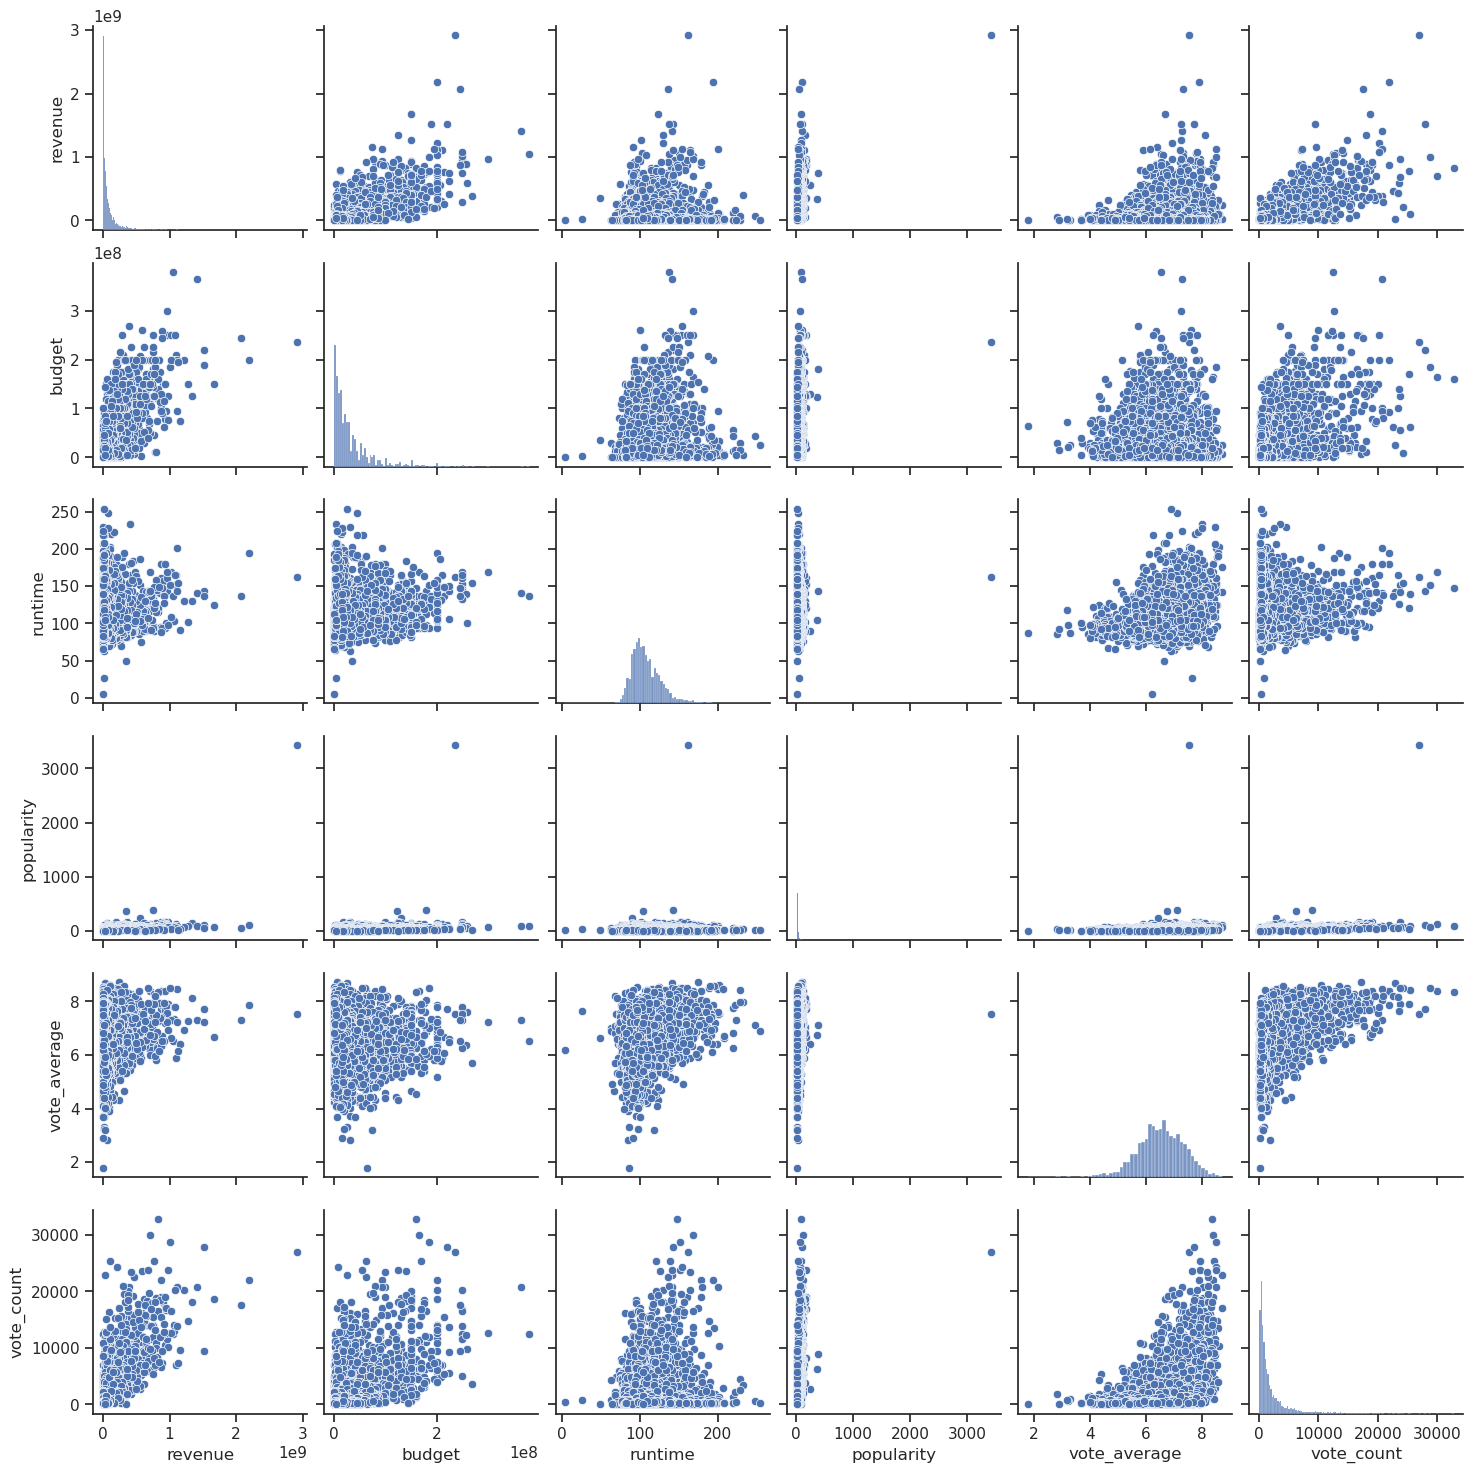

In [21]:
# Liens entre les variables quantitatives
sns.set(style="ticks", color_codes=True)
sns.pairplot(movies_df_quanti)
plt.show()

Ce graphique nous montre le lien entre chacune des 6 variables étudiées. Les graphiques les plus intéressants semblent être la recette en fonction du budget, ainsi que la recette en fonction du nombre de notes. 
##### On peut vérifier cette idée à l'aide d'une matrice de corrélation :

Text(0.5, 1.0, 'Matrice de corrélation entre les différentes caractéristiques des films\n')

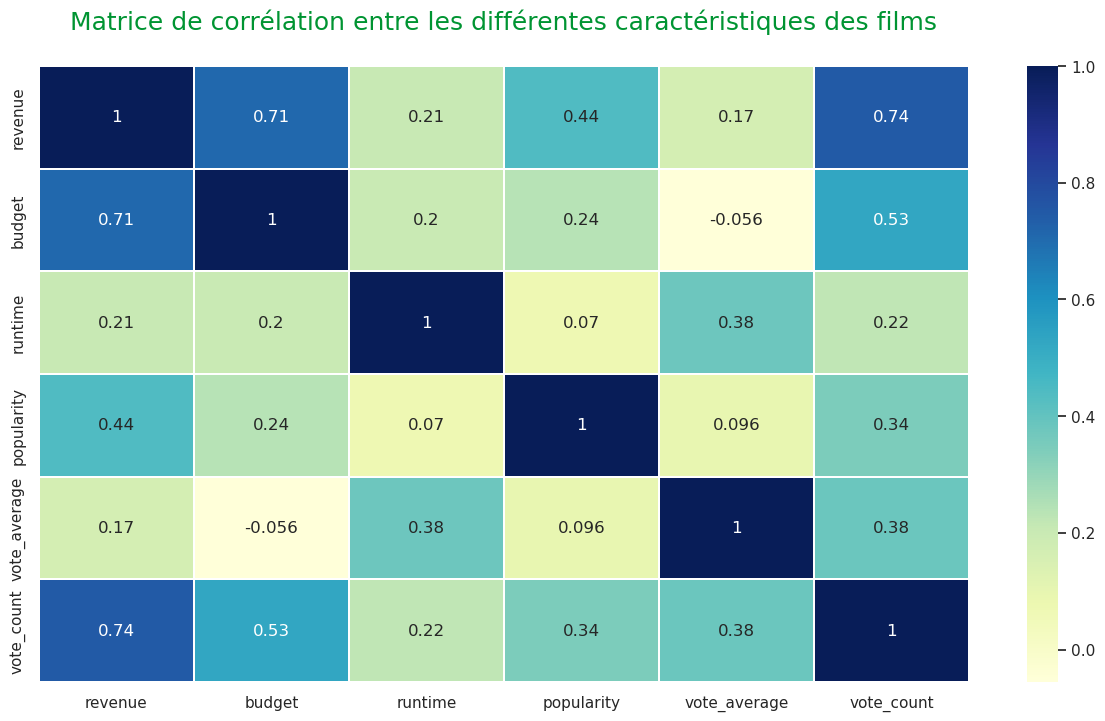

In [186]:
sns.heatmap(movies_df_quanti.corr(), cmap='YlGnBu', annot=True, linewidths = 0.2);
plt.title("Matrice de corrélation entre les différentes caractéristiques des films\n", fontsize=18, color='#009432')

Le plus gros coefficient correspond à la corrélation entre la recette et le budget. Cela nous laisse penser que plus le budget est élevé, plus la recette le sera également. Le budget apparait ainsi comme la variable la plus intéressante dans notre prédiction.
Encore une fois, on voit également une corrélation entre le nombre de notes et la recette. Plus des personnes notent un film, plus celui-ci a une recette élevée. Evidemment, la causalité est difficile à établir. On peut penser que le nombre de notes est un indicateur du nombre de personnes qui ont vu le film. Plus il y a eu de spectateurs, plus le film a une recette importante, ce qui parait logique. 

##### Focalisons-nous sur la relation entre la recette et le budget :

Text(0.5, 1.0, 'Recette en fonction du budget')

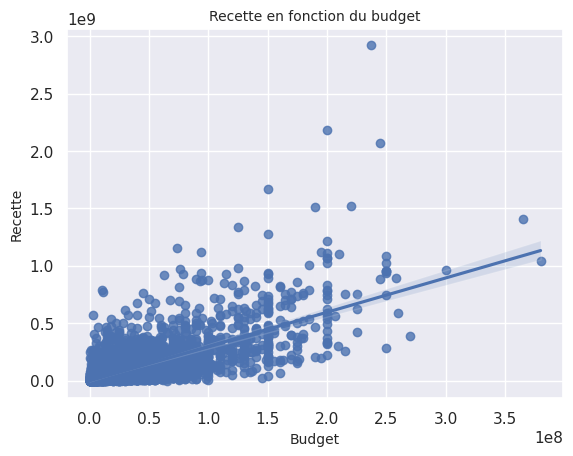

In [51]:
sns.regplot(data = movies_df, x = movies_df['budget'], y=movies_df['revenue'])
plt.xlabel("Budget", fontsize=10)  
plt.ylabel("Recette", fontsize=10)
plt.title("Recette en fonction du budget", fontsize=10)


##### Distributions de la recette et du budget :

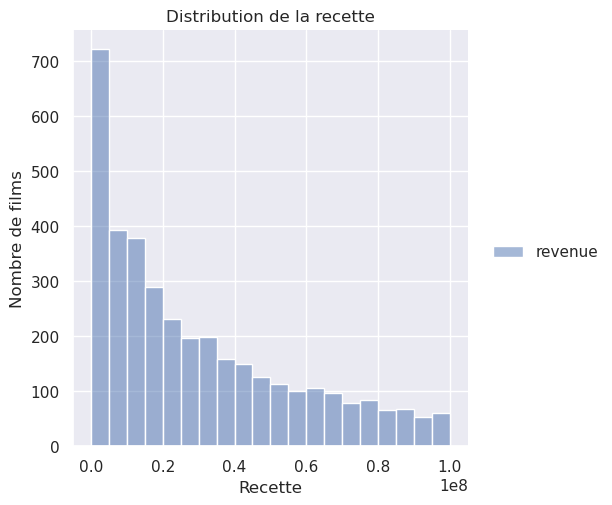

In [182]:
#On s'arrête au 3ème quartile pour que le graphique soit lisible
sns.displot(movies_df[['revenue']][movies_df.revenue < 1e8])
plt.title('Distribution de la recette')
plt.xlabel('Recette')
plt.ylabel('Nombre de films')
plt.show()

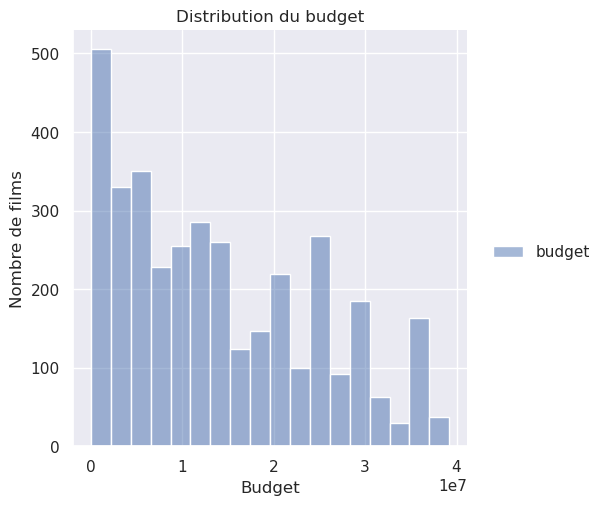

In [ ]:
#On s'arrête au 3ème quartile pour que le graphique soit lisible
sns.displot(movies_df[['budget']][movies_df.budget < 4e7])
plt.title('Distribution du budget')
plt.xlabel('Budget')
plt.ylabel('Nombre de films')
plt.show()

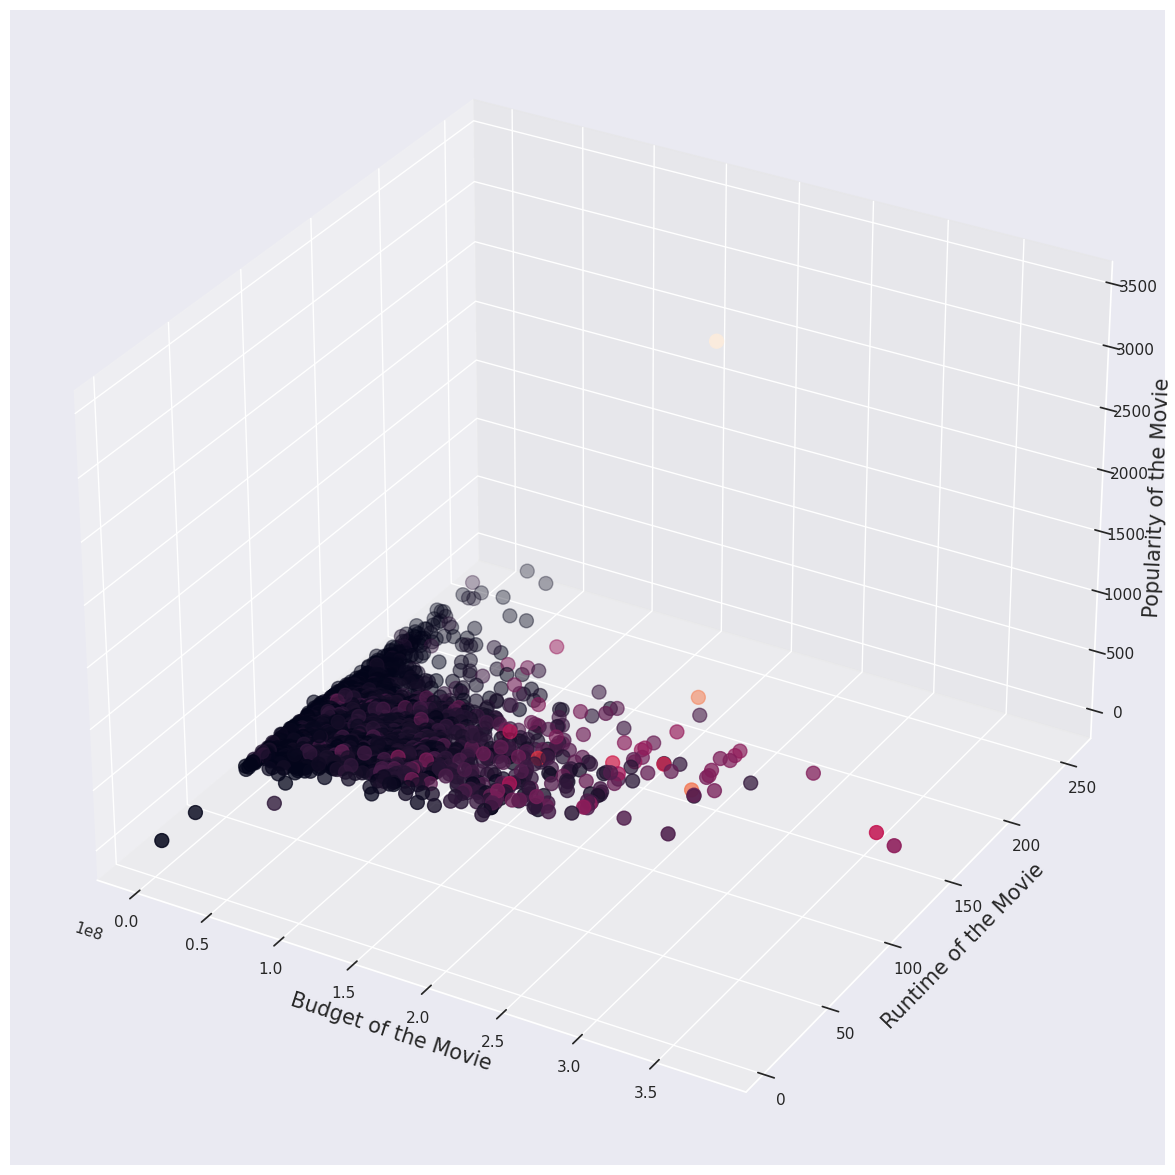

In [68]:
#Le graphique en 3 dimensions, j'ai pas compris, c = df ??

fig = plt.figure(figsize=(15,15))
ax = plt.subplot(111,projection = '3d')
ax.scatter(movies_df['budget'],movies_df['runtime'],movies_df['popularity'], c = movies_df['revenue'], marker = 'o', s = 100)
ax.set_xlabel('Budget of the Movie',fontsize=15)
ax.set_ylabel('Runtime of the Movie',fontsize=15)
ax.set_zlabel('Popularity of the Movie',fontsize=15)
plt.show()

### 2. Variables qualitatives

#### Langues et recette
##### On s'intéresse ici au lien entre la recette et la langue. Est-ce que celle-ci influence le revenu généré par le film ?

Text(0.5, 1.0, 'Recette du film en fonction de la langue originale')

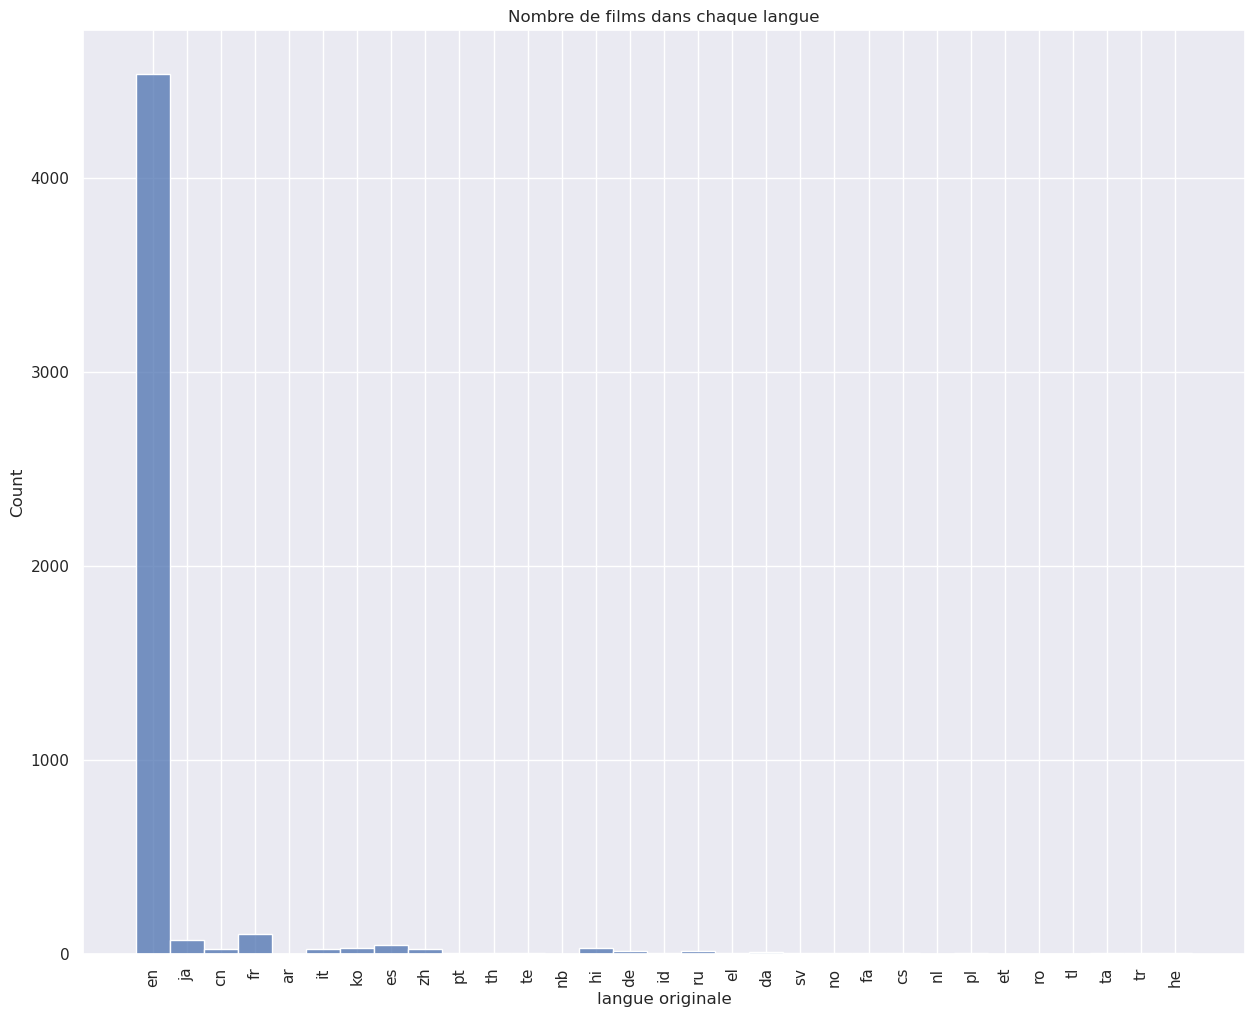

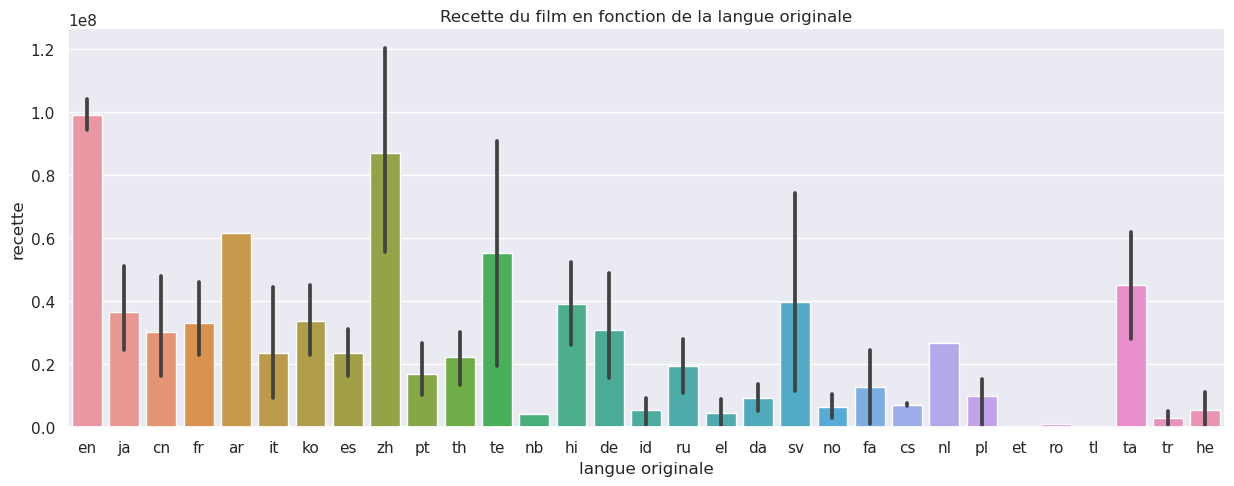

In [201]:
#Nombre de films dans chaque langue
plt.figure(figsize=(15,12)) 
sns.histplot(movies_df['original_language'])
plt.xticks(rotation=90)
plt.xlabel('langue originale')
plt.title('Nombre de films dans chaque langue')

#Recette en fonction de la langue originale
sns.catplot(x='original_language',y='revenue',data=movies_df, kind = 'bar', aspect = 2.5)
plt.xlabel('langue originale')
plt.ylabel('recette')
plt.title('Recette du film en fonction de la langue originale')


On constate que ce sont les films en anglais qui génèrent les plus grands revenus. Il y a d'ailleurs beaucoup plus de films en anglais qui sont produits que dans les autres langues. C'est une des langues les plus parlées au monde ce qui explique la popularité de tels films. 
##### Supprimons les films en anglais de la base de données pour pouvoir nous concentrer sur les autres langues : 

Text(0.5, 1.0, 'Recette du film en fonction de la langue originale')

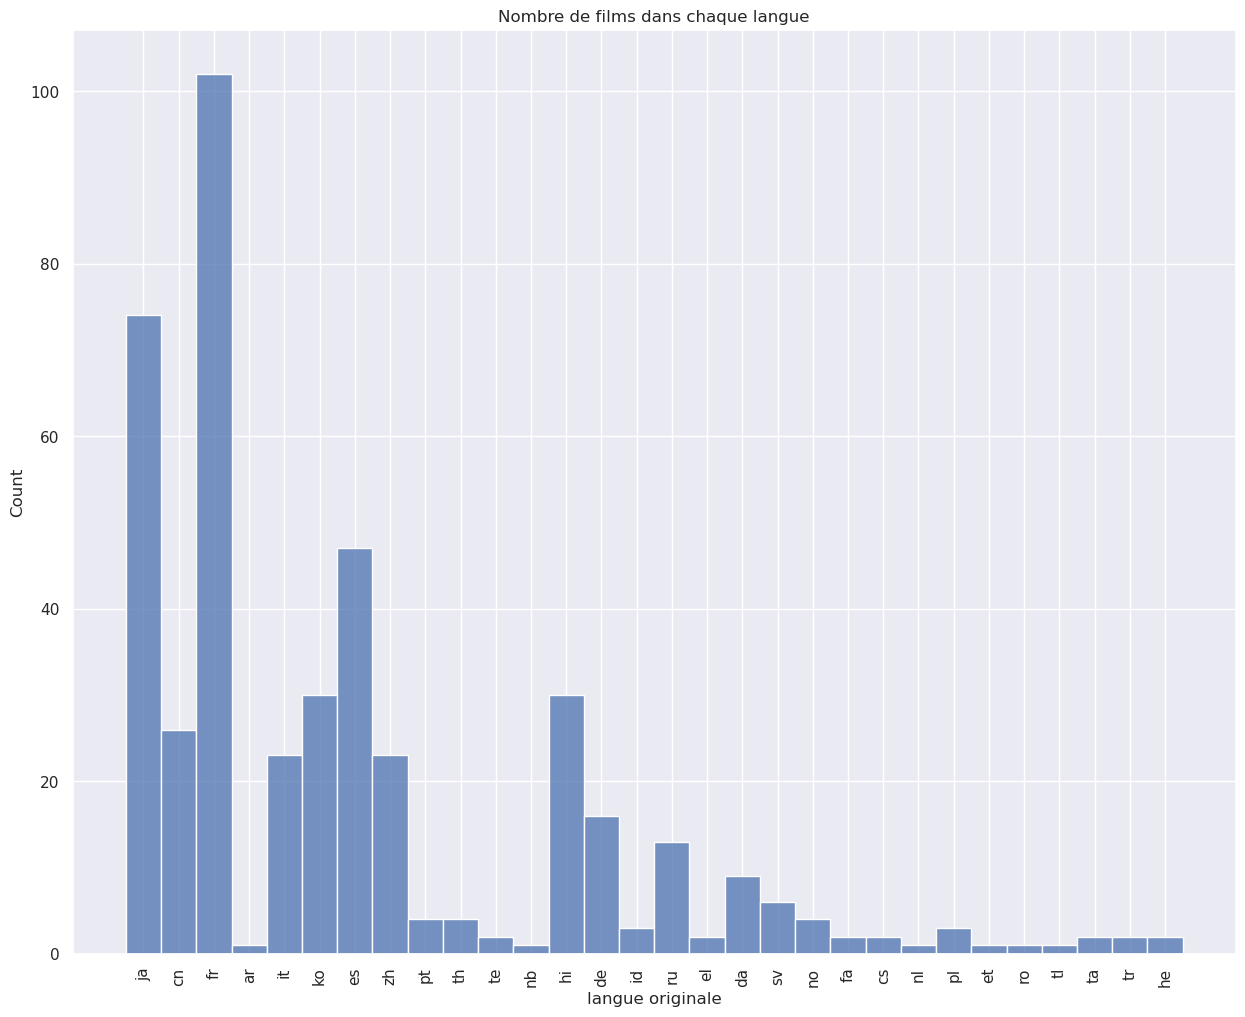

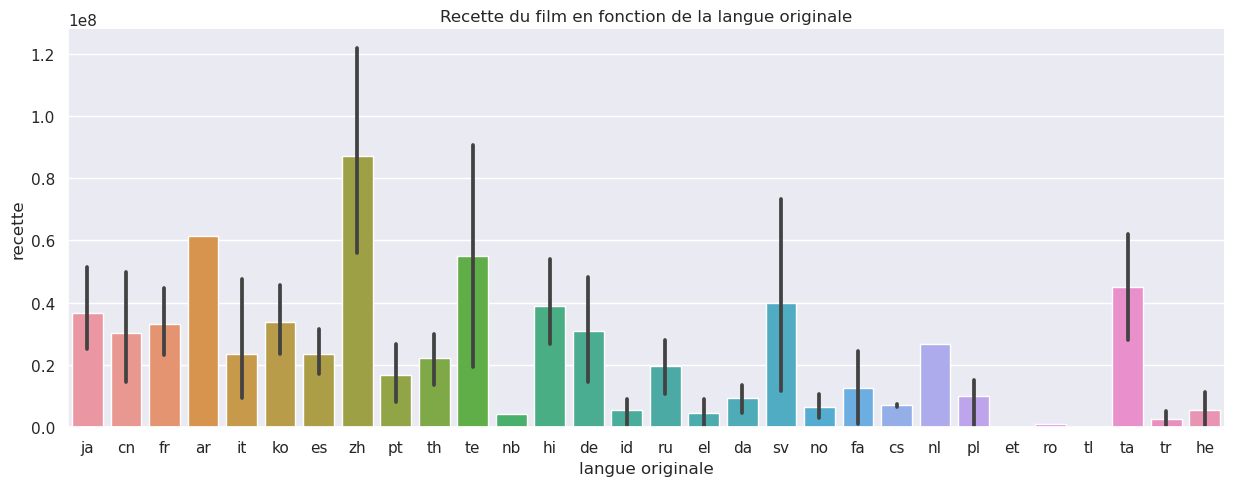

In [200]:
#On enlève les films en anglais
movies_df2 = movies_df.copy()
indexNames = movies_df2[movies_df2['original_language'] == 'en' ].index
movies_df2.drop(indexNames , inplace=True)

plt.figure(figsize=(15,12)) 
sns.histplot(movies_df2['original_language'])
plt.xticks(rotation=90)
plt.xlabel('langue originale')
plt.title('Nombre de films dans chaque langue')

sns.catplot(x='original_language',y='revenue',data=movies_df2, kind = 'bar', aspect = 2.5)
plt.xlabel('langue originale')
plt.ylabel('recette')
plt.title('Recette du film en fonction de la langue originale')


Les films en français et en japonais sont les plus nombreux. Ces deux pays ont effectivement une vieille tradition cinématographique, très reconnue. Toutefois, ce sont les films en chinois (zh) qui génèrent le plus de recette, suivi par l'arabe.

##### On s'intéresse au pays de production du film :

Text(0.5, 1.0, 'Recette du film en fonction du pays de production')

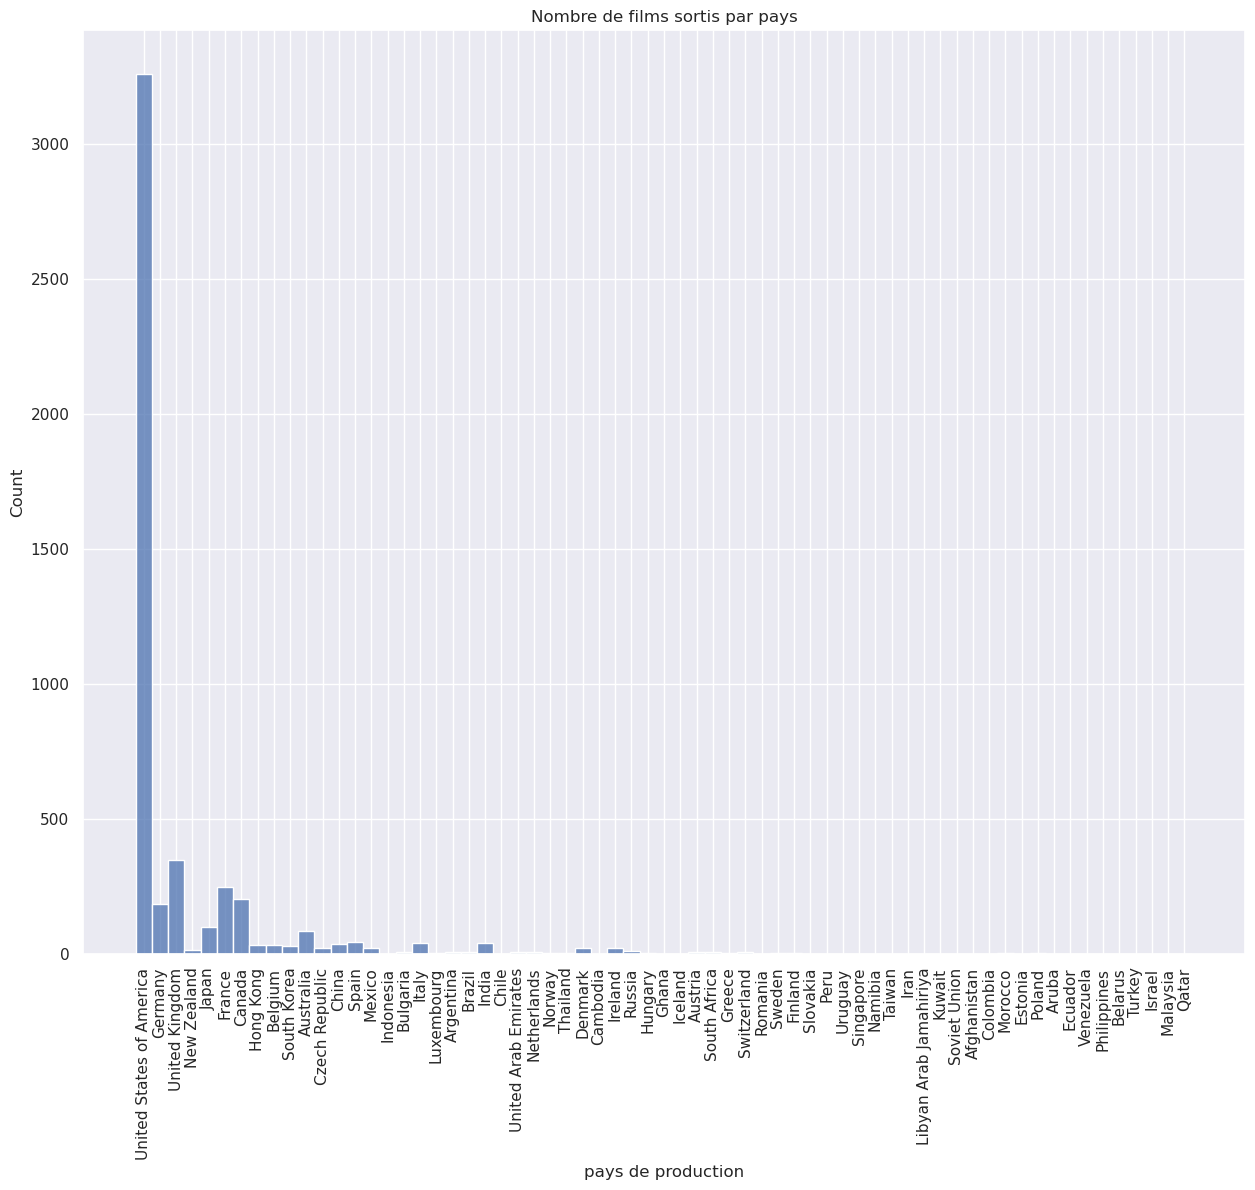

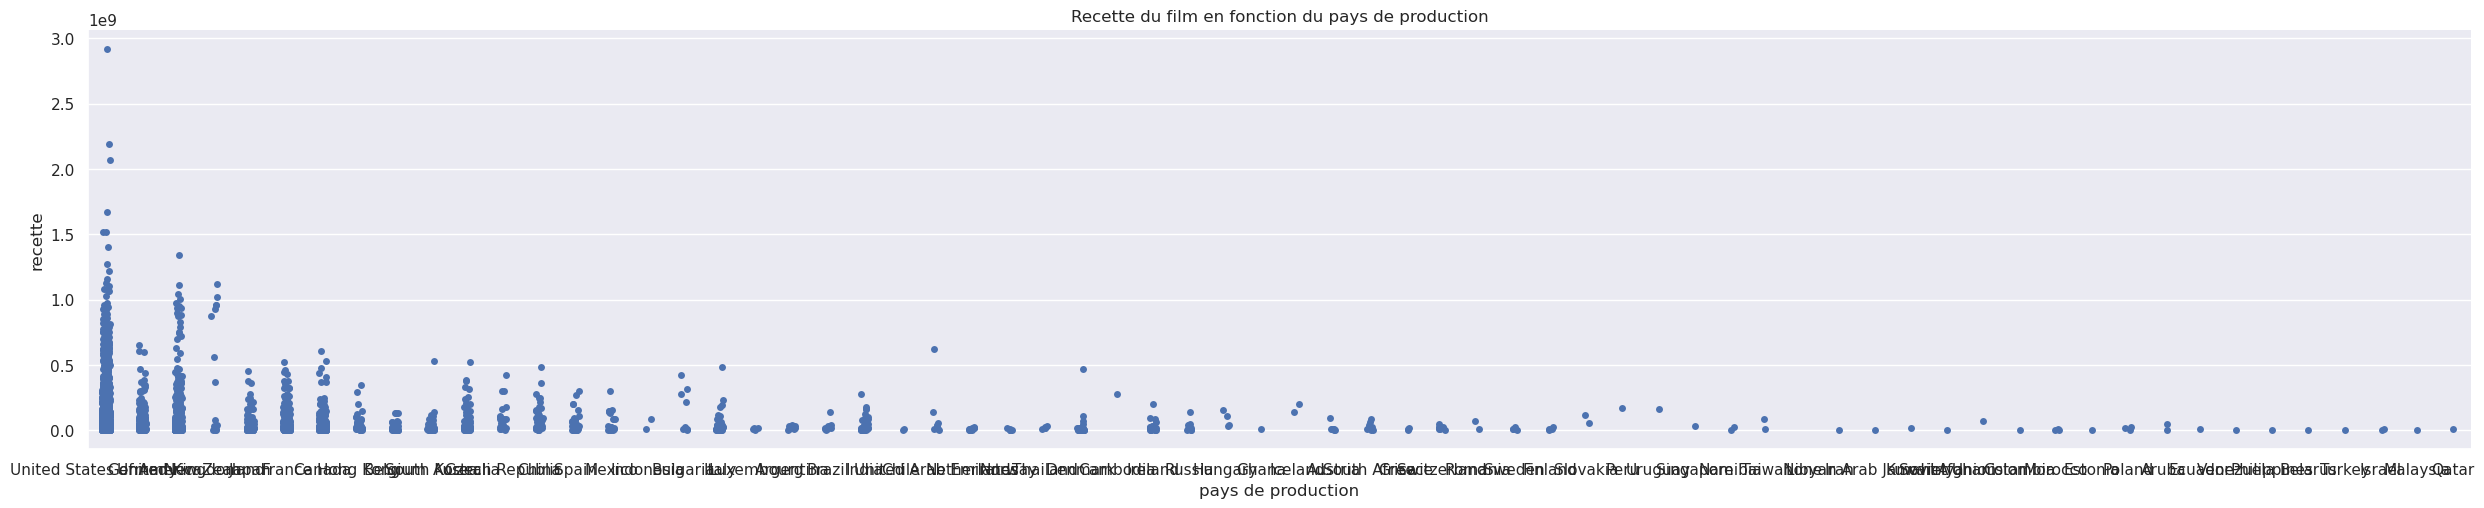

In [213]:
plt.figure(figsize=(15,12)) 
sns.histplot(tuple(movies_df['production_countries']))
plt.xticks(rotation=90)
plt.xlabel('pays de production')
plt.title('Nombre de films sortis par pays')

#Améliorer lisibilité
sns.catplot(x=tuple(movies_df['production_countries']),y='revenue',data=movies_df, aspect = 5)
plt.xlabel('pays de production')
plt.ylabel('recette')
plt.title('Recette du film en fonction du pays de production')


Ce sont bien les Etats-Unis qui dominent l'industrie du cinéma. En termes de recettes, les Etats-Unis et le Royaume-Uni dominent, suivis par l'Allemagne, la France, le Canada et l'Australie.

#### Recette et date de sortie

##### On s'intéresse à l'année de sortie :

Text(0.5, 1.0, "Recette du film en fonction de l'année de sortie")

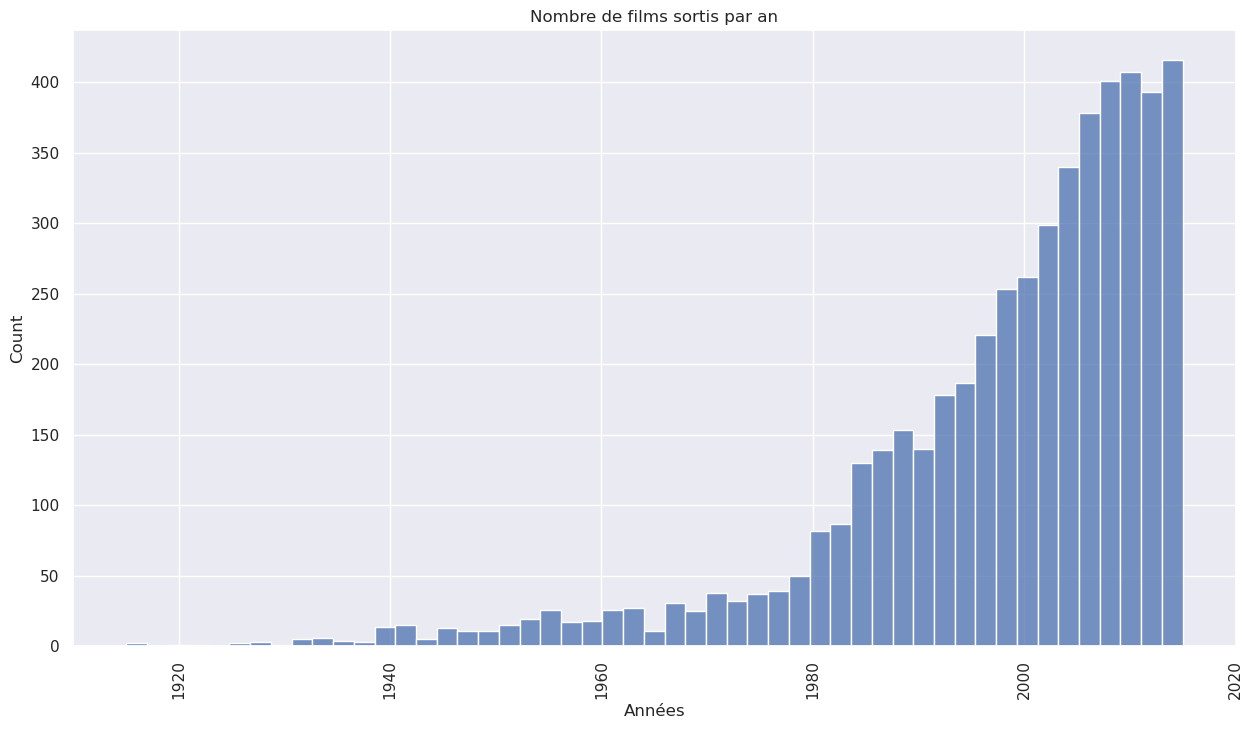

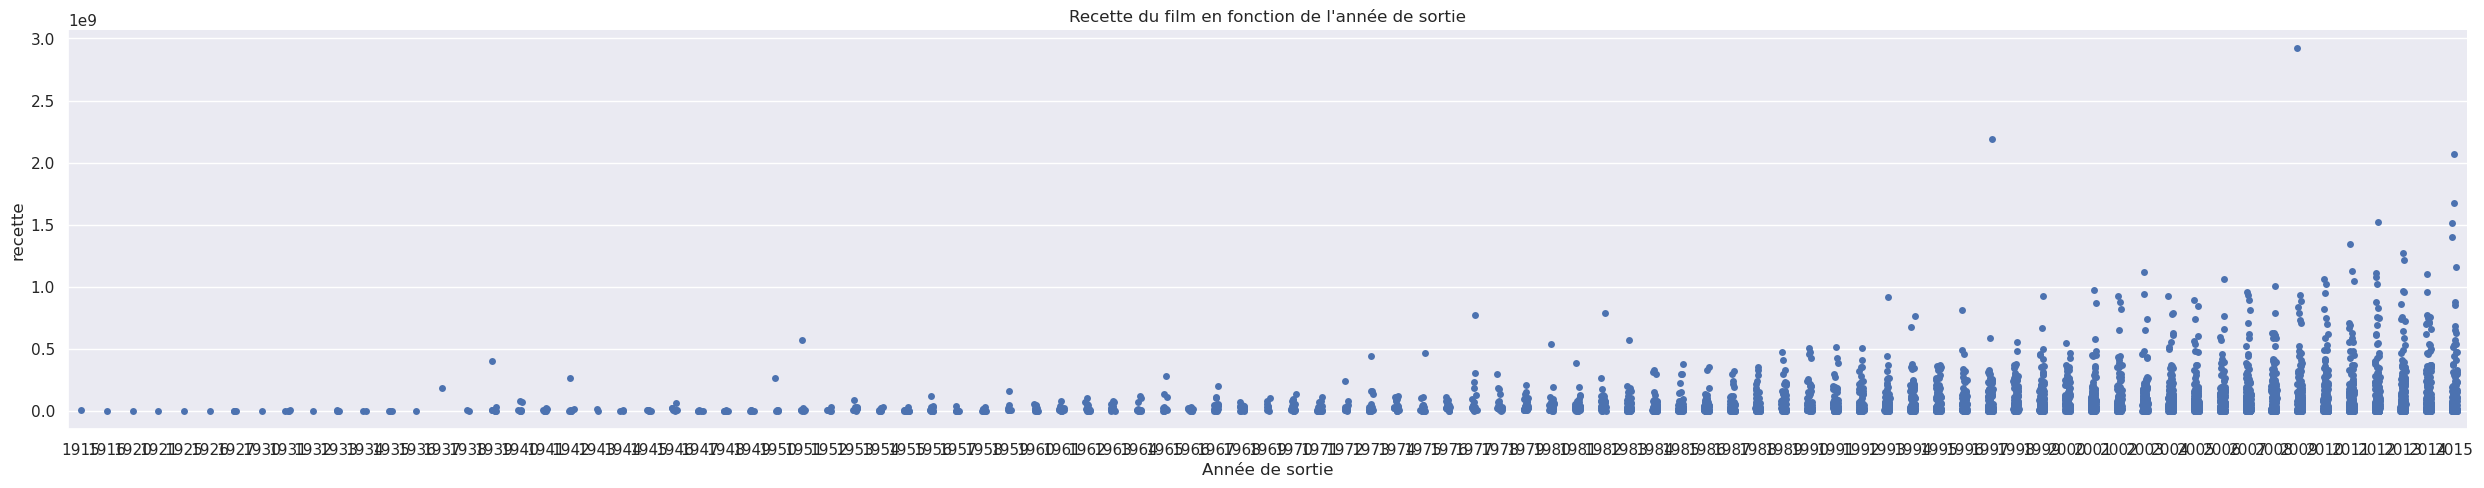

In [206]:
#Création d'une nouvelle variable : année de sortie
movies_df['date'] = pd.to_datetime(movies_df['release_date'],format='%Y-%m-%d')
movies_df['year'] = pd.DatetimeIndex(movies_df['date']).year

#Histogramme nombre de films sortis par an
sns.histplot(movies_df['year'])
plt.xticks(rotation=90)
plt.xlabel('Années')
plt.title('Nombre de films sortis par an')

#Recette en fonction des années
sns.catplot(x='year',y='revenue',data=movies_df, aspect = 5)
plt.xlabel('Année de sortie')
plt.ylabel('recette')
plt.title("Recette du film en fonction de l'année de sortie")


Le nombre de films réalisés depuis 1915 n'a fait que croitre, avec une augmentation très importante à partir des années 1980. En moyenne, cependant, on constate que les recettes n'ont pas augmenté aussi vite, bien qu'il existe chaque année des exceptions notables qui battent des records de revenu. On en conclut toutefois qu'un film sorti aujourd'hui fera certainement une recette plus importante qu'il y a 50 ans. 

##### On s'intéresse maintenant au mois de sortie : 

Text(0.5, 1.0, 'Recette du film en fonction du mois de sortie')

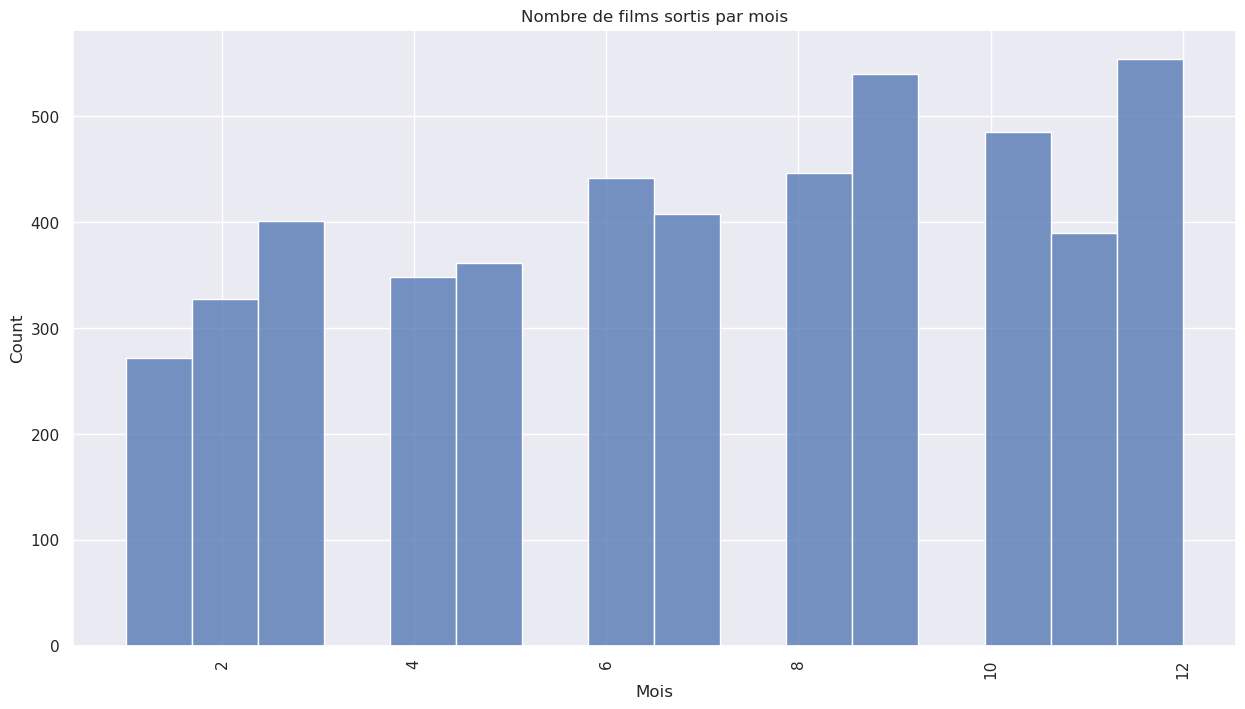

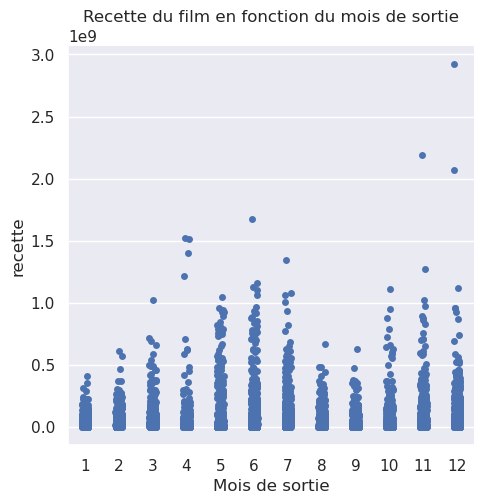

In [208]:
movies_df['date'] = pd.to_datetime(movies_df['release_date'],format='%Y-%m-%d')
movies_df['month'] = pd.DatetimeIndex(movies_df['date']).month

sns.histplot(movies_df['month'])
plt.xticks(rotation=90)
plt.xlabel('Mois')
plt.title('Nombre de films sortis par mois')

sns.catplot(x='month',y='revenue',data=movies_df)
plt.xlabel('Mois de sortie')
plt.ylabel('recette')
plt.title("Recette du film en fonction du mois de sortie")


Il y a plus de films qui sortent en fin d'année. On constate que ce sont les films sortis entre mai et juillet ou octobre et décembre qui ont les recettes les plus élevées. Janvier, au contraire, apparait comme un mois très peu prolifique dans le secteur du cinéma.

#### Genre et recette :

Text(0.5, 1.0, 'Recette du film en fonction du genre')

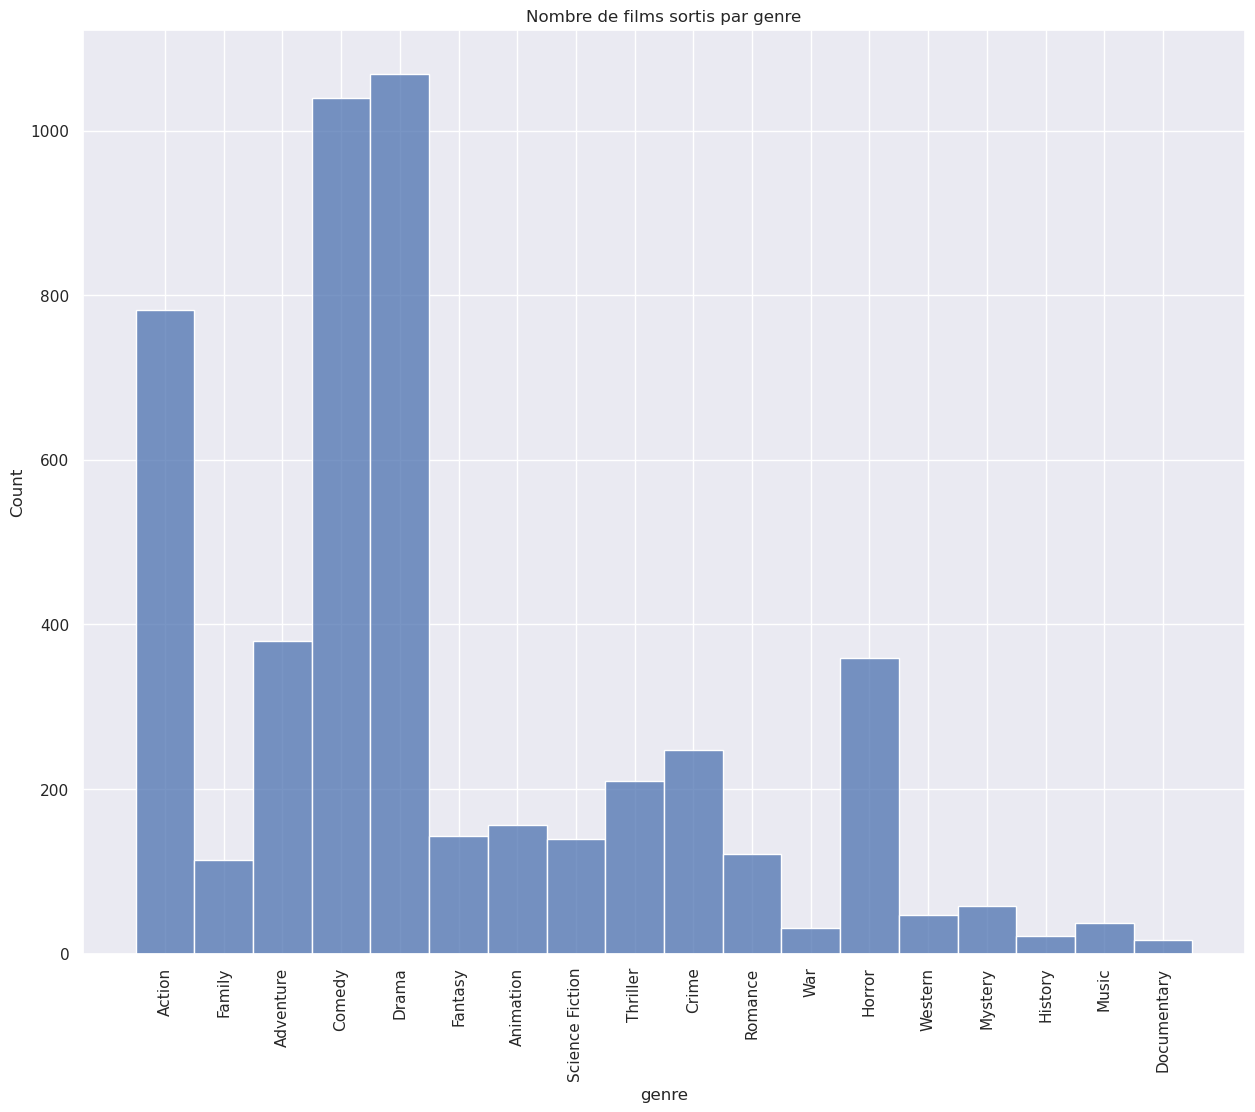

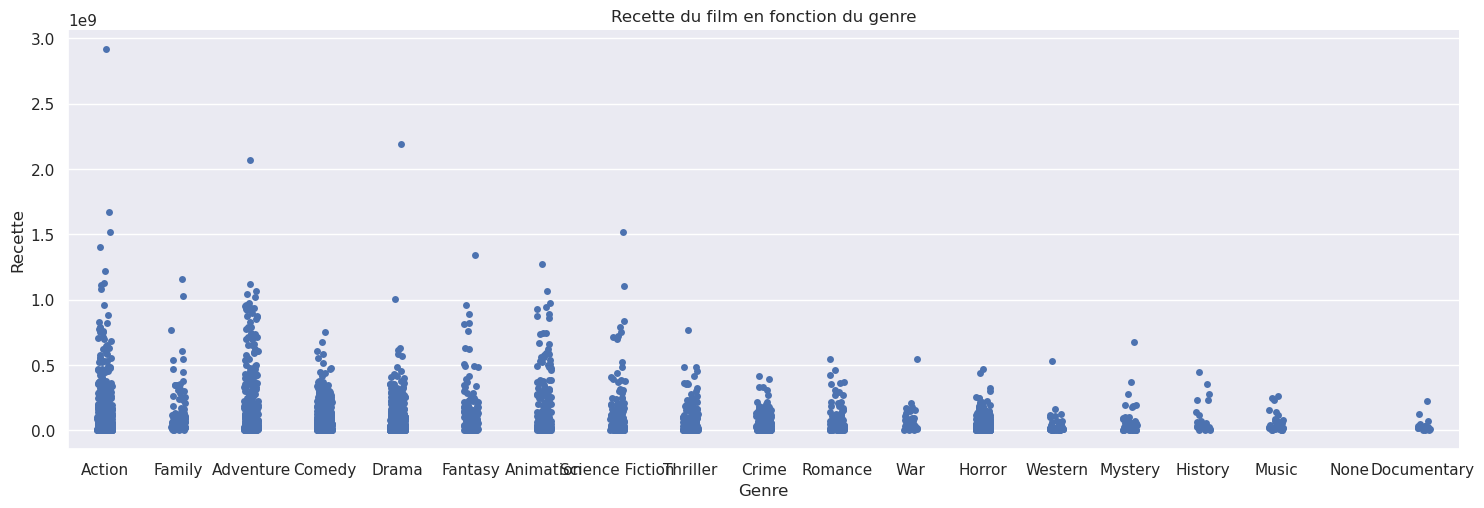

In [211]:
plt.figure(figsize=(15,12)) 
sns.histplot(tuple(movies_df['genres']))
plt.xticks(rotation=90)
plt.xlabel('genre')
plt.title('Nombre de films sortis par genre')

sns.catplot(x=tuple(movies_df['genres']),y='revenue',data=movies_df, aspect = 3)
plt.xlabel('Genre')
plt.ylabel('Recette')
plt.title("Recette du film en fonction du genre")


Les drames, les comédies, et les films d'action sont les genres les plus courants au cinéma. Les films d'action, les films d'aventure, les films fantastiques, de science-fiction et les animations apparaissent comme les genres générant les plus grosses recettes.

Un genre possède souvent un lexique particulier. Y a-t-il des mots clés dans le résumé d'un film qui assurent que celui-ci aura du succès ?
On réalise un nuage de mots pour voir quels sont les mots qui reviennent le plus souvent dans les taglines des films qui ont une recette supérieure au 3ème quartile. 

(1244, 17)


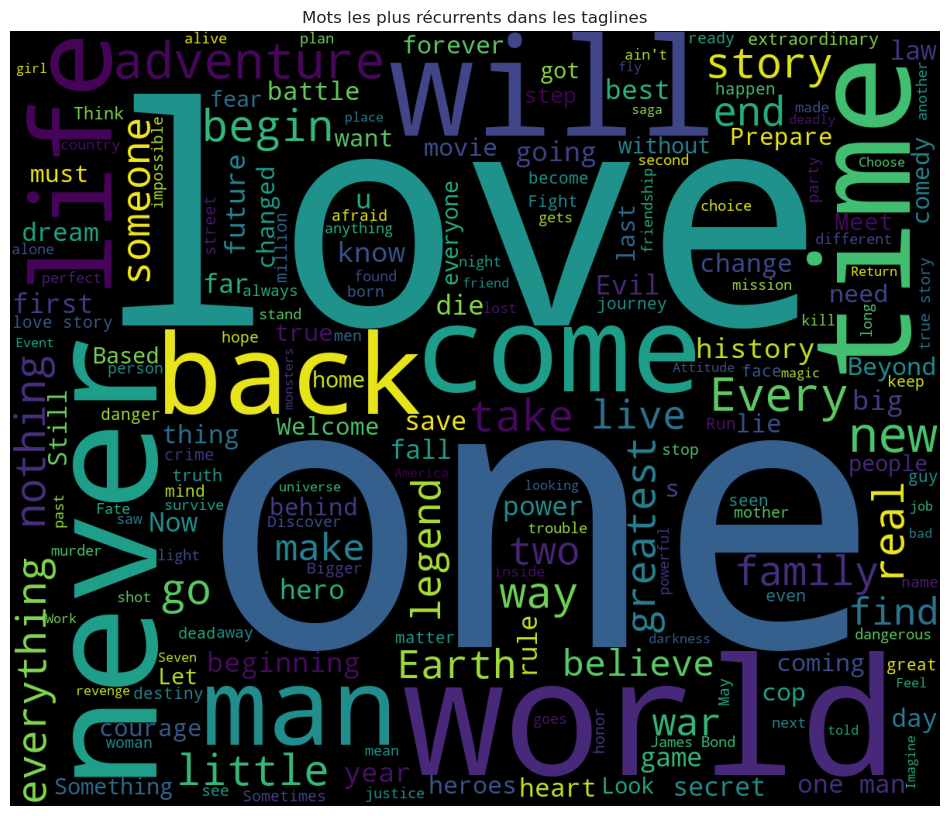

In [215]:
#on sélectionne les films dont la recette est supérieure au 3ème quartile
movies_df_bigrev = movies_df.query('revenue >= 1.039066e+08')
print(movies_df_bigrev.shape)

#On réalise le nuage de mots
plt.figure(figsize = (12, 12))
text = ' '.join(movies_df_bigrev['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Mots les plus récurrents dans les taglines')
plt.axis("off")
plt.show()

Des mots qu'on pourrait qualifier de "clichés" sortent du lot. Le mot "love" est extrêmement présent. On peut alors penser qu'un film ayant une dimension romantique a des chances d'avoir du succès. Les autres mots nous laissent également penser que les films évoquant la guerre, la famille, l'aventure, l'amitié, le destin... auront des recettes importantes. On peut remarquer que le nuage de mots affiche "James Bond", grande franchise à succès.

### 3. Les films à succès

##### Nous n'avons pour l'instant évoqué aucun film en particulier. Dans cette dernière partie, nous allons chercher les titres des films les plus populaires des dernières décennies, et nous intéresser à leurs caractéristiques. Qu'est-ce qui fait d'eux des films à succès ?

#### Top 10 des films avec la plus grosse recette :

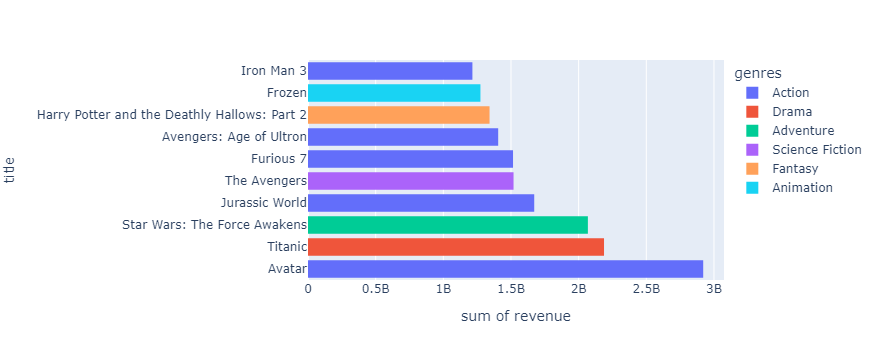

In [226]:
movies_df[["title", "revenue"]]

movies_films_pop = movies_df.sort_values(by ="revenue",ascending = False)
movies_films_pop = movies_films_pop[["title", "revenue", "genres"]].head(10)
px.histogram(data_frame = movies_films_pop,
                   x = 'revenue',
                   y = 'title',
                color = 'genres').update_yaxes(categoryorder='total descending')

Ce graphique représente le top 10 des films avec les revenus les plus élevés, on remarque que le film Avatar obtient le plus grand revenu. Par ailleurs, dans le top 10 des films avec les plus grands revenus se trouve majoritairement les films de genre action, ces films ont tendance à être les plus rentables.

#### Les films avec les budgets les plus élevés :

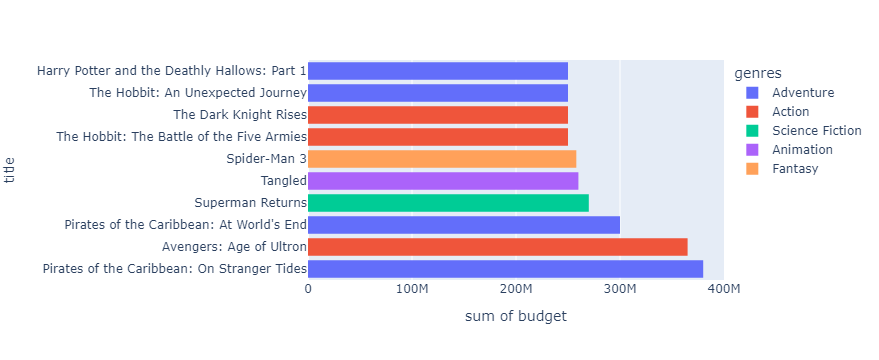

In [227]:
movies_df[["title", "budget"]]

movies_films_budget = movies_df.sort_values(by ="budget",ascending = False)
movies_films_budget = movies_films_budget[["title", "budget", "genres"]].head(10)
px.histogram(data_frame = movies_films_budget,
                   x = 'budget',
                   y = 'title',
                color = 'genres').update_yaxes(categoryorder='total descending')

On remarque que majoritairement ce sont les films d'actions et d'aventures qui ont les budgets les plus élevés.

#### Top 10 des films les plus populaires

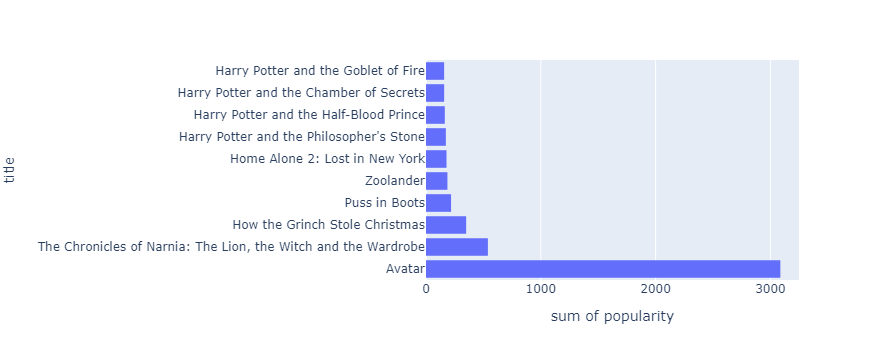

In [228]:
movies_df[["title", "popularity"]]
movies_films_popularity = movies_df.sort_values(by ="popularity",ascending = False)
movies_films_popularity = movies_films_popularity[["title", "popularity", "revenue"]].head(10)
px.histogram(data_frame = movies_films_popularity,
                   x = 'popularity',
                   y = 'title')

Le film Avatar est le film le plus populaire ce qui peut expliquer sa première place dans les profits générés.

#### La note moyenne des films par genre

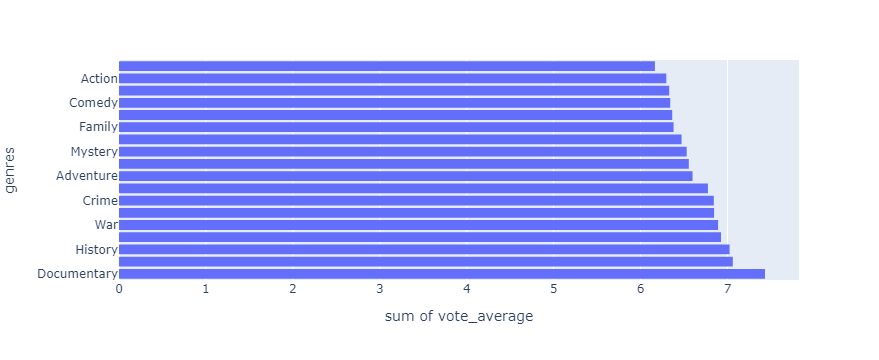

In [229]:
df_GenresVoteAverage = movies_df[["genres", "vote_average"]]
df_GenresVoteAverage = df_GenresVoteAverage.groupby("genres").mean().reset_index().sort_values(by='vote_average', ascending = False)
px.histogram(data_frame = df_GenresVoteAverage,
                   x = 'vote_average',
                   y = 'genres')

La note moyenne des films durant ces années a été d'envirion de 6. Par ailleurs ce sont les films de documentaire, Western et histoire qui ont les plus hautes moyennes, on peut faire l'hypothèse que ce sont des films avec le moins d'effectif de note. 

#### Les effectifs des notes par genre

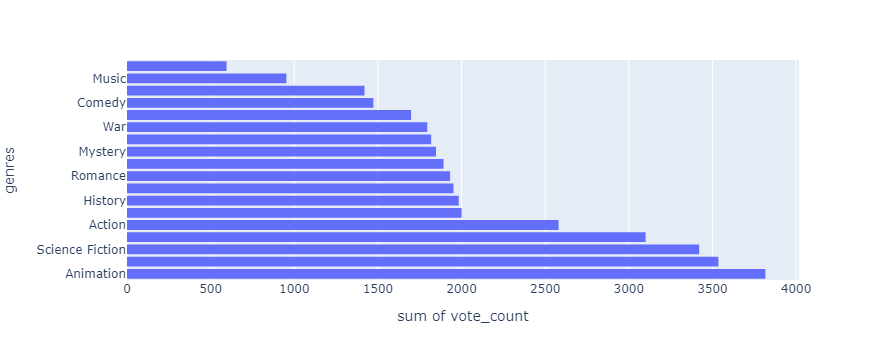

In [231]:
df_GenresVoteCount= movies_df[["genres", "vote_count"]]
df_GenresVoteCount = df_GenresVoteCount.groupby("genres").mean().reset_index().sort_values(by='vote_count', ascending = False)
px.histogram(data_frame = df_GenresVoteCount,
                   x = 'vote_count',
                   y = 'genres')

Notre hypothèse précédente se confirme avec ce graphe, en effet, nous pouvons voir que les films de Western, Documentaire ont peu de vote.

#### Films avec la durée la plus longue

In [232]:
df_GenresVoteRun= movies_df[["genres", "runtime"]]
df_GenresVoteRun = df_GenresVoteRun.sort_values(by='runtime', ascending = False)
df_GenresVoteRun.head(10)

genres  runtime
7605        Drama      254
1846        Drama      248
1132        Drama      233
1163        Drama      229
1675    Adventure      228
9252  Documentary      225
6625    Adventure      224
1155       Action      222
433         Drama      220
8051        Drama      219

Dans un premier temps, nous pouvons voir que les 10 premiers films avec la durée la plus longue ce sont les films drame.